In [1]:
import pyopencl as cl
import pyopencl.cltypes
import numpy as np

In [2]:
exp_min = -14
exp_max = 8
num_axis_points = 500

axis = np.logspace( exp_min, exp_max, num_axis_points, base=10.0, dtype=np.float64)

In [3]:
from numpy.random import Generator, MT19937
seed = 20210515
prng = Generator(MT19937(seed))

In [4]:
def get_all_devices():
    devices = []
    pp = cl.get_platforms()
    for p in pp:
        dd = p.get_devices()
        for d in dd:
            devices.append( d )
    return devices

In [5]:
def run_benchmark( ctx, kernel, x, y, x_out, y_out, num_repetitions=3):
    assert len( x ) > 0
    assert len( x ) == len( y )
    assert len( x ) == len( x_out )
    assert len( x ) == len( y_out )
    times = np.zeros( num_repetitions )
    
    if num_repetitions < 1:
        num_repetitions = 1
        
    with cl.CommandQueue( ctx, properties=cl.command_queue_properties.PROFILING_ENABLE ) as queue:
        x_out_arg = cl.Buffer( ctx, cl.mem_flags.READ_WRITE, size=x_out.nbytes )
        y_out_arg = cl.Buffer( ctx, cl.mem_flags.READ_WRITE, size=y_out.nbytes )
        x_arg = cl.Buffer( ctx, cl.mem_flags.READ_ONLY, size=x.nbytes )
        y_arg = cl.Buffer( ctx, cl.mem_flags.READ_ONLY, size=y.nbytes )
        
        
        for ii in range( num_repetitions ):
            if ii % 10 == 0:
                print( f"start repetition {(ii+1):3d} / {num_repetitions:3d}" )
            cl.enqueue_copy( queue, x_arg, x )        
            ev = cl.enqueue_copy( queue, y_arg, y )
            queue.finish()
    
            kernel.set_args( cl.cltypes.long( len( x ) ), x_arg, y_arg, x_out_arg, y_out_arg )
            ev = cl.enqueue_nd_range_kernel( queue, kernel, x.shape, None )
            queue.finish()
            ev.wait()            
            times[ ii ] = ( ev.profile.end - ev.profile.start ) * 1e-9     
        
        del x_out_arg
        del x_arg
        del y_out_arg
        del y_arg
    return times

In [6]:
!clinfo -l

dlerror: libintelocl_emu.so: cannot open shared object file: No such file or directory
dlerror: libalteracl.so: cannot open shared object file: No such file or directory
dlerror: libtbb.so.12: cannot open shared object file: No such file or directory
dlerror: libalteracl.so: cannot open shared object file: No such file or directory
dlerror: libintelocl.so: cannot open shared object file: No such file or directory
dlerror: libintelocl_emu.so: cannot open shared object file: No such file or directory
Platform #0: Portable Computing Language
 `-- Device #0: pthread-AMD Ryzen 7 3800X 8-Core Processor
Platform #1: AMD Accelerated Parallel Processing
 `-- Device #0: gfx900:xnack-
Platform #2: NVIDIA CUDA
 +-- Device #0: GeForce GTX 1050 Ti
 `-- Device #1: GeForce GT 710


In [7]:
devices = get_all_devices()
print( f"number of devices found: {len(devices)}" )

used_device_ids = [ 0, 2, 3 ]
used_devices    = { ii: devices[ ii ] for ii in used_device_ids }
contexts        = { ii: cl.Context(devices=[devices[ii]]) for ii in used_device_ids }
for ii in used_device_ids:
    print( devices[ ii ] )

number of devices found: 4
<pyopencl.Device 'GeForce GTX 1050 Ti' on 'NVIDIA CUDA' at 0x2de44b0>
<pyopencl.Device 'gfx900:xnack-' on 'AMD Accelerated Parallel Processing' at 0x2d93850>
<pyopencl.Device 'pthread-AMD Ryzen 7 3800X 8-Core Processor' on 'Portable Computing Language' at 0x2de1130>


In [8]:
%env PYOPENCL_COMPILER_OUTPUT=1

env: PYOPENCL_COMPILER_OUTPUT=1


In [9]:
!rm -rf ~/.nv/ComputeCache/

In [10]:
# This is a HACK!!

import os
current_path = os.getcwd()
print( current_path )

/home/martin/git/faddeevas


In [11]:
prog_c = { ii: cl.Program( contexts[ ii ], """
#include "cernlib_c/ErrorFunctions.h"

__kernel void eval_cerrf( 
    long int const num_arguments,
    __global double const* __restrict x_vec, 
    __global double const* __restrict y_vec, 
    __global double* __restrict x_out_vec, 
    __global double* __restrict y_out_vec )
{
    long int const ii =  get_global_id( 0 );
    if( ii < num_arguments )
    {
        double x_out, y_out;        
        cerrf( x_vec[ ii ], y_vec[ ii ], &x_out, &y_out );
        x_out_vec[ ii ] = x_out;
        y_out_vec[ ii ] = y_out;
    }
}""") for ii in used_device_ids }

for ii in used_device_ids:
    prog_c[ ii ].build( options = [ "-D_GPUCODE=1", "-DCERRF_NO_SYSTEM_INCLUDES=1", f"-I{current_path}" ] )

/home/martin/.virtualenvs/work38/lib/python3.8/site-packages/pyopencl/__init__.py:264: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'gfx900:xnack-' on 'AMD Accelerated Parallel Processing' at 0x2d93850> succeeded, but said:

2 warnings generated.

  warn(text, CompilerWarning)


In [12]:
prog_c_rev1 = { ii: cl.Program( contexts[ ii ], """
#include "cernlib_rev_c/ErrorFunctions.h"

__kernel void eval_cerrf( 
    long int const num_arguments,
    __global double const* __restrict x_vec, 
    __global double const* __restrict y_vec, 
    __global double* __restrict x_out_vec, 
    __global double* __restrict y_out_vec )
{
    long int const ii =  get_global_id( 0 );
    if( ii < num_arguments )
    {
        double x_out, y_out;        
        cerrf_rev( x_vec[ ii ], y_vec[ ii ], &x_out, &y_out );
        x_out_vec[ ii ] = x_out;
        y_out_vec[ ii ] = y_out;
    }
}""") for ii in used_device_ids }

for ii in used_device_ids:
    prog_c_rev1[ ii ].build( options = [ "-D_GPUCODE=1", "-DCERRF_NO_SYSTEM_INCLUDES=1", f"-I{current_path}" ] )

In [39]:
prog_c_rev2 = { ii: cl.Program( contexts[ ii ], """
#include "cernlib_rev2_c/ErrorFunctions.h"

__kernel void eval_cerrf( 
    long int const num_arguments,
    __global double const* __restrict x_vec, 
    __global double const* __restrict y_vec, 
    __global double* __restrict x_out_vec, 
    __global double* __restrict y_out_vec )
{
    long int const ii =  get_global_id( 0 );
    if( ii < num_arguments )
    {
        double x_out, y_out;        
        cerrf_rev2( x_vec[ ii ], y_vec[ ii ], &x_out, &y_out );
        x_out_vec[ ii ] = x_out;
        y_out_vec[ ii ] = y_out;
    }
}""") for ii in used_device_ids }

for ii in used_device_ids:
    prog_c_rev2[ ii ].build( options = [ "-D_GPUCODE=1", "-DCERRF_NO_SYSTEM_INCLUDES=1", f"-I{current_path}" ] )

/home/martin/.virtualenvs/work38/lib/python3.8/site-packages/pyopencl/__init__.py:264: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'gfx900:xnack-' on 'AMD Accelerated Parallel Processing' at 0x2d93850> succeeded, but said:

2 warnings generated.

  warn(text, CompilerWarning)


## Fully randomised arguments over complex plane 

In [14]:
import numpy
from numpy.random import Generator, MT19937

full_random_times = { ii: { "c":{}, "rev1":{}, "rev2":{} } for ii in used_device_ids }
full_random_info  = { ii: { "c":{}, "rev1":{}, "rev2":{} } for ii in used_device_ids }
num_args = np.array( [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75,
                       80, 85, 90, 95, 100, 120, 140, 160, 180, 200, 220, 240, 250, 260, 280, 300, 
                      320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 600, 700, 750, 800, 900, 
                      1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000 ] ) * 1024
EPS  = float( 2.2e-16 )
prng = Generator(MT19937(20150512))

print( "\r\n*** cernlib_c kernel:" )

xlim = 5.33
ylim = 4.29

for ii in used_device_ids:
    print( f"**** device: {ii} :: {devices[ii]}")
    for N in num_args:
        x = prng.uniform( -np.sqrt( 2.0 ) * xlim, np.sqrt( 2.0 ) * xlim, N )
        y = prng.uniform( -np.sqrt( 2.0 ) * ylim, np.sqrt( 2.0 ) * ylim, N )
        x_out = np.zeros( N )
        y_out = np.zeros( N )
        
        print( f"*** N = {N:8d}" ) 
        kernel = prog_c[ ii ].eval_cerrf
        full_random_info[ ii ][ "c" ][ "WORK_GROUP_SIZE" ] = kernel.get_work_group_info( 
            cl.kernel_work_group_info.WORK_GROUP_SIZE, devices[ ii ] )
        full_random_info[ ii ][ "c" ][ "PRIVATE_MEM_SIZE" ] = kernel.get_work_group_info(
            cl.kernel_work_group_info.PRIVATE_MEM_SIZE, devices[ ii ] )
        full_random_times[ ii ][ "c" ][ N ] = run_benchmark( 
            contexts[ii], kernel, x, y, x_out, y_out, num_repetitions=50 )

print( "\r\n*** cernlib_rev1_c kernel:" )

for ii in used_device_ids:
    print( f"**** device: {ii} :: {devices[ii]}")
    for N in num_args:
        x = prng.uniform( -np.sqrt( 2.0 ) * xlim, np.sqrt( 2.0 ) * xlim, N )
        y = prng.uniform( -np.sqrt( 2.0 ) * ylim, np.sqrt( 2.0 ) * ylim, N )
        x_out = np.zeros( N )
        y_out = np.zeros( N )
        
        print( f"*** N = {N:8d}" ) 
        kernel = prog_c_rev1[ ii ].eval_cerrf
        full_random_info[ ii ][ "rev1" ][ "WORK_GROUP_SIZE" ] = kernel.get_work_group_info( 
            cl.kernel_work_group_info.WORK_GROUP_SIZE, devices[ ii ] )
        full_random_info[ ii ][ "rev1" ][ "PRIVATE_MEM_SIZE" ] = kernel.get_work_group_info(
            cl.kernel_work_group_info.PRIVATE_MEM_SIZE, devices[ ii ] )
        full_random_times[ ii ][ "rev1" ][ N ] = run_benchmark( 
            contexts[ii], kernel, x, y, x_out, y_out, num_repetitions=50 )
        


*** cernlib_c kernel:
**** device: 0 :: <pyopencl.Device 'GeForce GTX 1050 Ti' on 'NVIDIA CUDA' at 0x2de44b0>
*** N =     1024
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     2048
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     3072
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     4096
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     5120
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     6144
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
star

start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  1024000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  1536000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2048000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2560000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3072000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3584000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start r

*** N =   430080
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   450560
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   471040
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   491520
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   512000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   614400
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   716800
start repetition   1 /  50
start repetition  11 /  50
start repetition 

start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   256000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   266240
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   286720
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   307200
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   327680
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   348160
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start r

start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    97280
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   102400
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   122880
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   143360
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   163840
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   184320
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start r

*** N =    46080
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    51200
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    56320
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    61440
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    66560
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    71680
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    76800
start repetition   1 /  50
start repetition  11 /  50
start repetition 

start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    20480
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    25600
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    30720
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    35840
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    40960
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    46080
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start r

In [40]:
print( "\r\n*** cernlib_rev2_c kernel:" )

for ii in used_device_ids:
    print( f"**** device: {ii} :: {devices[ii]}")
    for N in num_args:
        x = prng.uniform( -np.sqrt( 2.0 ) * xlim, np.sqrt( 2.0 ) * xlim, N )
        y = prng.uniform( -np.sqrt( 2.0 ) * ylim, np.sqrt( 2.0 ) * ylim, N )
        x_out = np.zeros( N )
        y_out = np.zeros( N )
        
        print( f"*** N = {N:8d}" ) 
        kernel = prog_c_rev2[ ii ].eval_cerrf
        full_random_info[ ii ][ "rev2" ][ "WORK_GROUP_SIZE" ] = kernel.get_work_group_info( 
            cl.kernel_work_group_info.WORK_GROUP_SIZE, devices[ ii ] )
        full_random_info[ ii ][ "rev2" ][ "PRIVATE_MEM_SIZE" ] = kernel.get_work_group_info(
            cl.kernel_work_group_info.PRIVATE_MEM_SIZE, devices[ ii ] )
        full_random_times[ ii ][ "rev2" ][ N ] = run_benchmark( 
            contexts[ii], kernel, x, y, x_out, y_out, num_repetitions=50 )


*** cernlib_rev2_c kernel:
**** device: 0 :: <pyopencl.Device 'GeForce GTX 1050 Ti' on 'NVIDIA CUDA' at 0x2de44b0>
*** N =     1024
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     2048
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     3072
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     4096
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     5120
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     6144
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50

start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  1024000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  1536000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2048000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2560000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3072000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3584000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start r

start repetition  41 /  50
*** N =   430080
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   450560
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   471040
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   491520
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   512000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   614400
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   716800
start repetition   1 /  50
start repetition 

start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   266240
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   286720
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   307200
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   327680
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   348160
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   368640
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start r

In [16]:
print( full_random_info )

{0: {'c': {'WORK_GROUP_SIZE': 256, 'PRIVATE_MEM_SIZE': 568}, 'rev1': {'WORK_GROUP_SIZE': 256, 'PRIVATE_MEM_SIZE': 40}, 'rev2': {'WORK_GROUP_SIZE': 256, 'PRIVATE_MEM_SIZE': 40}}, 2: {'c': {'WORK_GROUP_SIZE': 256, 'PRIVATE_MEM_SIZE': 536}, 'rev1': {'WORK_GROUP_SIZE': 256, 'PRIVATE_MEM_SIZE': 0}, 'rev2': {'WORK_GROUP_SIZE': 256, 'PRIVATE_MEM_SIZE': 0}}, 3: {'c': {'WORK_GROUP_SIZE': 4096, 'PRIVATE_MEM_SIZE': 1024}, 'rev1': {'WORK_GROUP_SIZE': 4096, 'PRIVATE_MEM_SIZE': 1024}, 'rev2': {'WORK_GROUP_SIZE': 4096, 'PRIVATE_MEM_SIZE': 1024}}}


In [75]:
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [114]:
def plot_variant_norm_times_for_device( device, num_args, data, title_str = "Title", 
        colors = [ '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', ],
        markers = ['+', 'x', '*', '^', '>', '<' ], base_variant='c' ):
    dev_name = device.get_info( cl.device_info.NAME )
    nn = np.zeros( len( num_args ) )
    p50 = { variant : np.zeros( len( num_args ) ) for variant in data.keys() }
    p10 = { variant : np.zeros( len( num_args ) ) for variant in data.keys() }
    p90 = { variant : np.zeros( len( num_args ) ) for variant in data.keys() }
    ylim_min =  1e30
    ylim_max = -1e30
    assert len( data.keys() ) <= len( colors )
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), )
        
    for kk, variant in enumerate( data.keys() ):
        for jj, N in enumerate( num_args ):
            nn[ jj ] = float( N )
            np.sort( data[ variant ][ N ] )
            p50[ variant ][ jj ] = np.percentile( data[ variant ][ N ], 50.0 ) /  nn[ jj ]
            p10[ variant ][ jj ] = np.percentile( data[ variant ][ N ], 10.0 ) /  nn[ jj ]
            p90[ variant ][ jj ] = np.percentile( data[ variant ][ N ], 90.0 ) /  nn[ jj ]
    
    for kk, variant in enumerate( data.keys() ):    
        ax1.plot( nn, p50[ variant ], label=f'Median \"{variant}\"', color=colors[ kk ], marker=markers[ kk ] )
        ax1.plot( nn, p10[ variant ], label=f'90-10 percentile \"{variant}\"', color=colors[ kk ], linestyle='--' )
        ax1.plot( nn, p90[ variant ], color=colors[ kk ], linestyle='--' )
        ax1.fill_between( nn, p10[ variant ], p90[ variant ], alpha=0.2, color=colors[ kk ] )
        
        if variant == base_variant:
            ax2.plot( nn, np.ones( len( nn ), dtype=np.float64),
                      label=f"Baseline \"{base_variant}\"", color=colors[kk], linestyle="-." )
            continue
            
        ylim_min = min( ylim_min, np.floor( np.amin( p50[ base_variant ] / p50[ variant ] ) ) )
        ylim_max = max( ylim_max, np.ceil( np.amax( p50[ base_variant ] / p50[ variant ] ) ) )
                                           
        ax2.plot( nn, p50[ base_variant ] / p50[ variant ], 
                  label=f"Median improvement \"{variant}\" over \"{base_variant}\"", 
                  color=colors[kk], marker=markers[kk] )        
         
    if ylim_min > 0.0:
        ylim_min = 0.0
        
    if ylim_max <= 1.0:
        ylim_max = 1.2
            
    ax1.grid( which="major", axis="y" )
    ax1.yaxis.set_minor_locator( AutoMinorLocator())
    ax1.grid( which="minor", axis="y", linestyle="--" )
    ax1.legend(fontsize=14.0)
    ax1.set_xscale( 'log' )    
    ax1.set_xlabel( r"Number of arguments to faddeeva function $N$", fontsize=14.0 )
    ax1.set_ylabel( r"Normalised execution time $t_{elapsed} / N [s/\mathrm{arg}]$", fontsize=14.0 )
    
    ax2.grid( which="major", axis="y" )
    ax2.grid( which="minor", axis="y", linestyle="--" )
    ax2.set_xscale( "log" )
    ax2.legend(fontsize=14.0)
    ax2.set_xlabel( r"Number of arguments to faddeeva function $N$", fontsize=14.0 )
    ax2.set_ylabel( f"Improvement of revions over baseline \"{base_variant}\" (factor)", fontsize=14.0 )
    ax2.set_ylim( [ ylim_min, ylim_max ] )
    
    plt.suptitle( f"{title_str}\nDevice: {dev_name}", fontsize=16.0 )
    
    
    

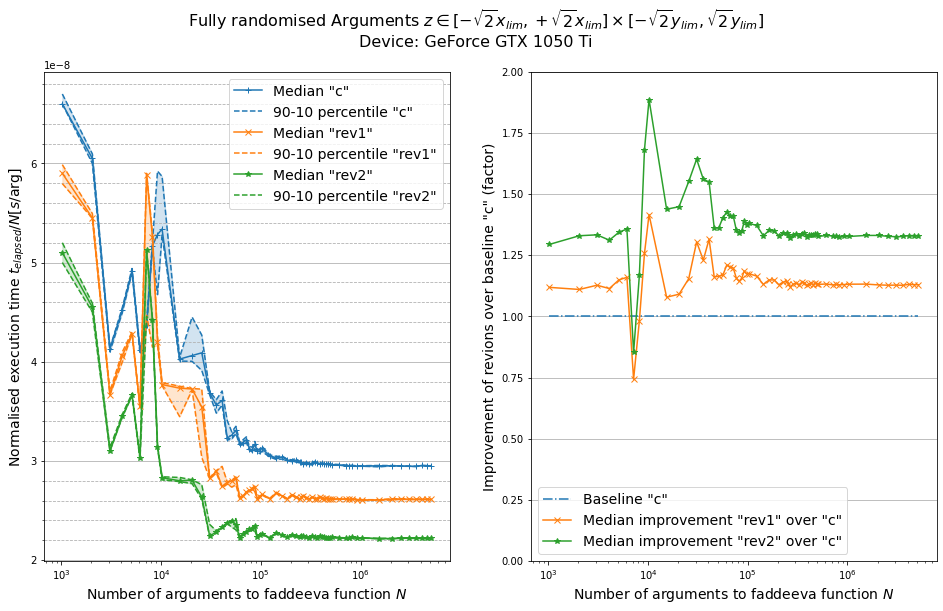

In [103]:
title_str = r"Fully randomised Arguments $z \in [-\sqrt{2} x_{lim}, +\sqrt{2} x_{lim} ] \times [-\sqrt{2} y_{lim}, \sqrt{2} y_{lim}]$"
plot_variant_norm_times_for_device( devices[ used_device_ids[ 0 ] ], num_args, full_random_times[ used_device_ids[ 0 ] ], title_str)
plt.savefig( './cmp_opencl_full_randomised_r0_nvidia_gtx1050ti_cuda11.svg')

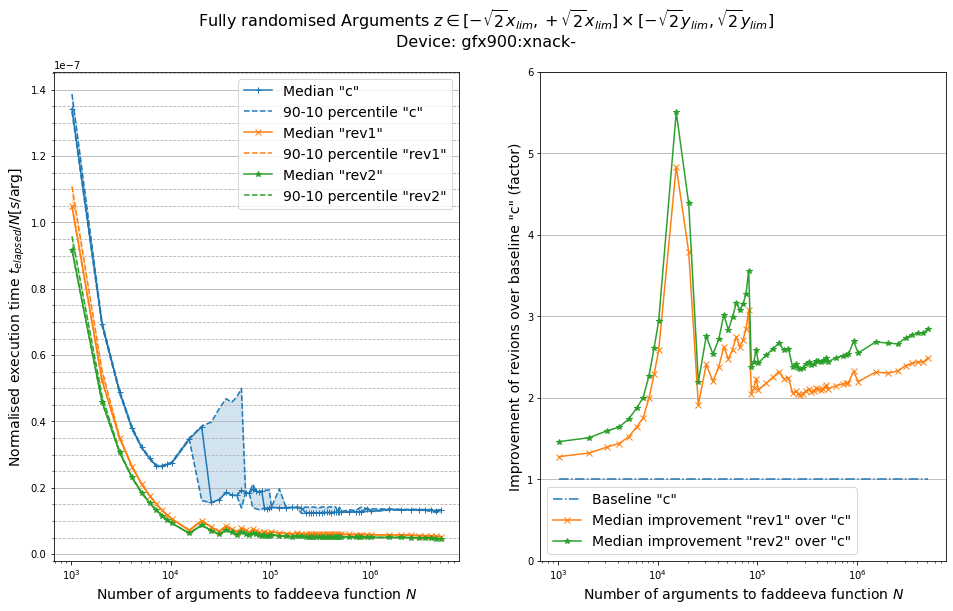

In [106]:
plot_variant_norm_times_for_device( devices[ used_device_ids[ 1 ] ], num_args, full_random_times[ used_device_ids[ 1 ] ], title_str)
plt.rcParams["figure.figsize"] = (12,9)
plt.savefig( './cmp_opencl_full_randomised_r0_amd_vega64_rocm42.svg')

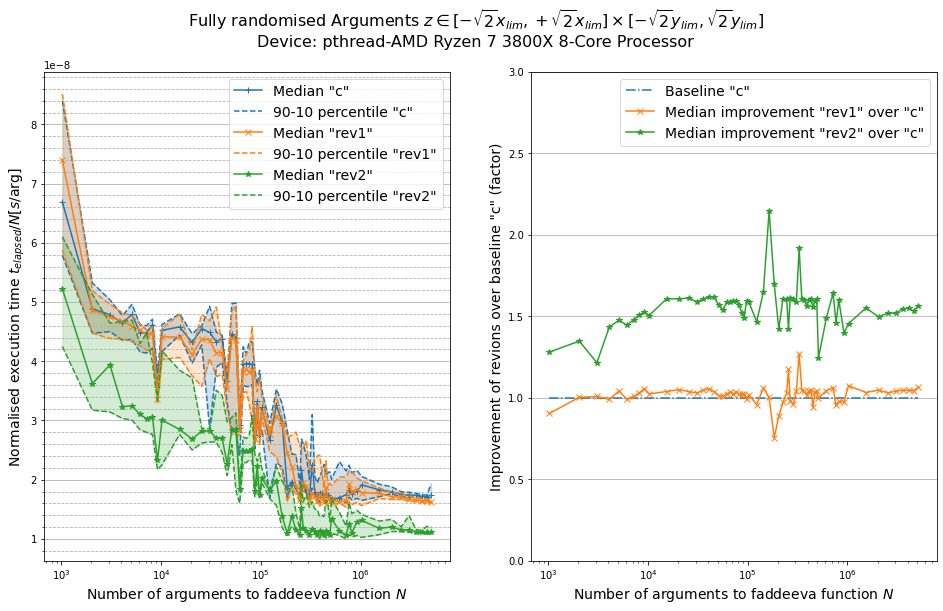

In [107]:
plot_variant_norm_times_for_device( devices[ used_device_ids[ 2 ] ], num_args, full_random_times[ used_device_ids[ 2 ] ], title_str)
plt.rcParams["figure.figsize"] = (12,9)
plt.savefig( './cmp_opencl_full_randomised_amd_3800X_cpu_pocl.svg')

## Randomized inside R0 = $[0, x_{lim}] \times [0, y_{lim}]$

In [46]:
r0_random_times = { ii: { "c":{}, "rev1":{}, "rev2":{} } for ii in used_device_ids }
r0_random_info  = { ii: { "c":{}, "rev1":{}, "rev2":{} } for ii in used_device_ids }
num_args = np.array( [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75,
                       80, 85, 90, 95, 100, 120, 140, 160, 180, 200, 220, 240, 250, 260, 280, 300, 
                      320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 600, 700, 750, 800, 900, 
                      1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000 ] ) * 1024
EPS  = float( 2.2e-16 )
prng = Generator(MT19937(20150512))

print( "\r\n*** cernlib_c kernel:" )

xlim = 5.33
ylim = 4.29

for ii in used_device_ids:
    print( f"**** device: {ii} :: {devices[ii]}")
    for N in num_args:
        x = prng.uniform( 0.0, EPS + xlim, N )
        y = prng.uniform( 0.0, EPS + xlim, N )
        x_out = np.zeros( N )
        y_out = np.zeros( N )
        
        print( f"*** N = {N:8d}" ) 
        kernel = prog_c[ ii ].eval_cerrf
        r0_random_times[ ii ][ "c" ][ N ] = run_benchmark( 
            contexts[ii], kernel, x, y, x_out, y_out, num_repetitions=50 )

print( "\r\n*** cernlib_rev1_c kernel:" )

for ii in used_device_ids:
    print( f"**** device: {ii} :: {devices[ii]}")
    for N in num_args:
        x = prng.uniform( 0.0, EPS + xlim, N )
        y = prng.uniform( 0.0, EPS + xlim, N )
        x_out = np.zeros( N )
        y_out = np.zeros( N )
        
        print( f"*** N = {N:8d}" ) 
        kernel = prog_c_rev1[ ii ].eval_cerrf        
        r0_random_times[ ii ][ "rev1" ][ N ] = run_benchmark( 
            contexts[ii], kernel, x, y, x_out, y_out, num_repetitions=50 )


*** cernlib_c kernel:
**** device: 0 :: <pyopencl.Device 'GeForce GTX 1050 Ti' on 'NVIDIA CUDA' at 0x2de44b0>
*** N =     1024
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     2048
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     3072
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     4096
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     5120
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     6144
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
star

start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  1024000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  1536000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2048000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2560000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3072000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3584000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start r

*** N =   430080
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   450560
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   471040
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   491520
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   512000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   614400
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   716800
start repetition   1 /  50
start repetition  11 /  50
start repetition 

start repetition  31 /  50
start repetition  41 /  50
*** N =   256000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   266240
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   286720
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   307200
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   327680
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   348160
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   368640
start repetition 

start repetition  31 /  50
start repetition  41 /  50
*** N =    97280
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   102400
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   122880
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   143360
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   163840
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   184320
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   204800
start repetition 

*** N =    51200
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    56320
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    61440
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    66560
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    71680
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    76800
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    81920
start repetition   1 /  50
start repetition  11 /  50
start repetition 

start repetition  31 /  50
start repetition  41 /  50
*** N =    15360
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    20480
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    25600
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    30720
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    35840
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    40960
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    46080
start repetition 

In [47]:
print( "\r\n*** cernlib_rev2_c kernel:" )

for ii in used_device_ids:
    print( f"**** device: {ii} :: {devices[ii]}")
    for N in num_args:
        x = prng.uniform( 0.0, EPS + xlim, N )
        y = prng.uniform( 0.0, EPS + xlim, N )
        x_out = np.zeros( N )
        y_out = np.zeros( N )
        
        print( f"*** N = {N:8d}" ) 
        kernel = prog_c_rev2[ ii ].eval_cerrf
        r0_random_times[ ii ][ "rev2" ][ N ] = run_benchmark( 
            contexts[ii], kernel, x, y, x_out, y_out, num_repetitions=50 )


*** cernlib_rev2_c kernel:
**** device: 0 :: <pyopencl.Device 'GeForce GTX 1050 Ti' on 'NVIDIA CUDA' at 0x2de44b0>
*** N =     1024
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     2048
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     3072
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     4096
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     5120
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     6144
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50

start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  1024000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  1536000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2048000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2560000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3072000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3584000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start r

start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   450560
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   471040
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   491520
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   512000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   614400
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   716800
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =

start repetition  41 /  50
*** N =   256000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   266240
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   286720
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   307200
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   327680
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   348160
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   368640
start repetition   1 /  50
start repetition 

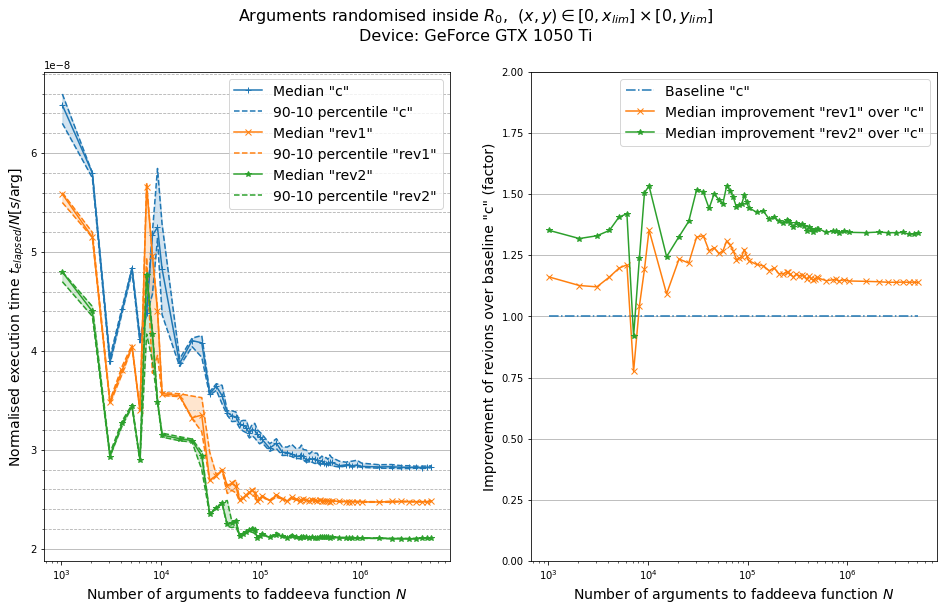

In [122]:
title_str =  r"Arguments randomised inside $R_0$,  $(x,y) \in [0, x_{lim} ] \times [0, y_{lim}]$"
plot_variant_norm_times_for_device( devices[ used_device_ids[ 0 ] ], num_args, r0_random_times[ used_device_ids[ 0 ] ], title_str)
plt.savefig( './cmp_opencl_randomised_r0_nvidia_gtx1050ti_cuda11.svg')

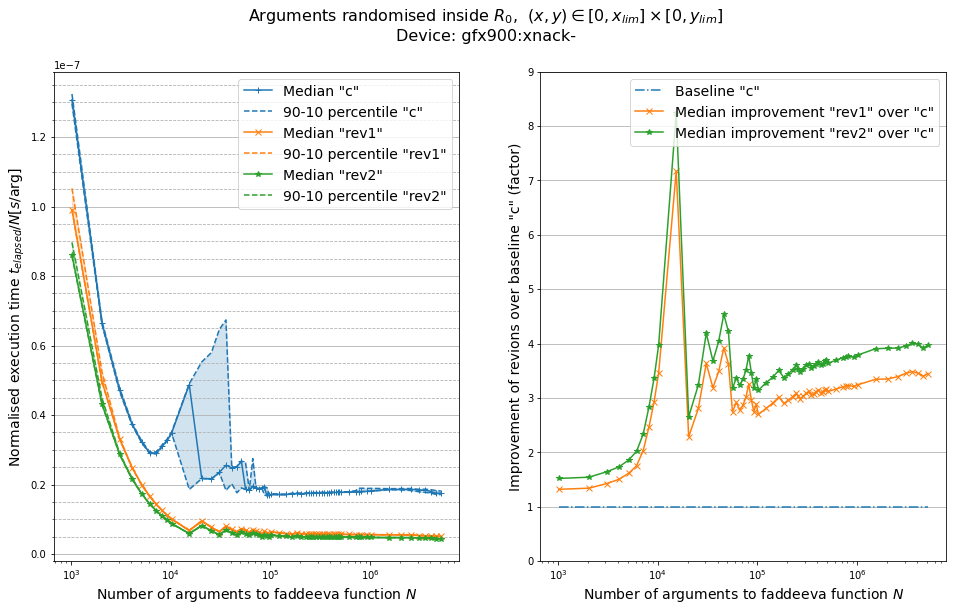

In [123]:
plot_variant_norm_times_for_device( devices[ used_device_ids[ 1 ] ], num_args, r0_random_times[ used_device_ids[ 1 ] ], title_str)
plt.rcParams["figure.figsize"] = (12,9)
plt.savefig( './cmp_opencl_randomised_r0_amd_vega64_rocm42.svg')

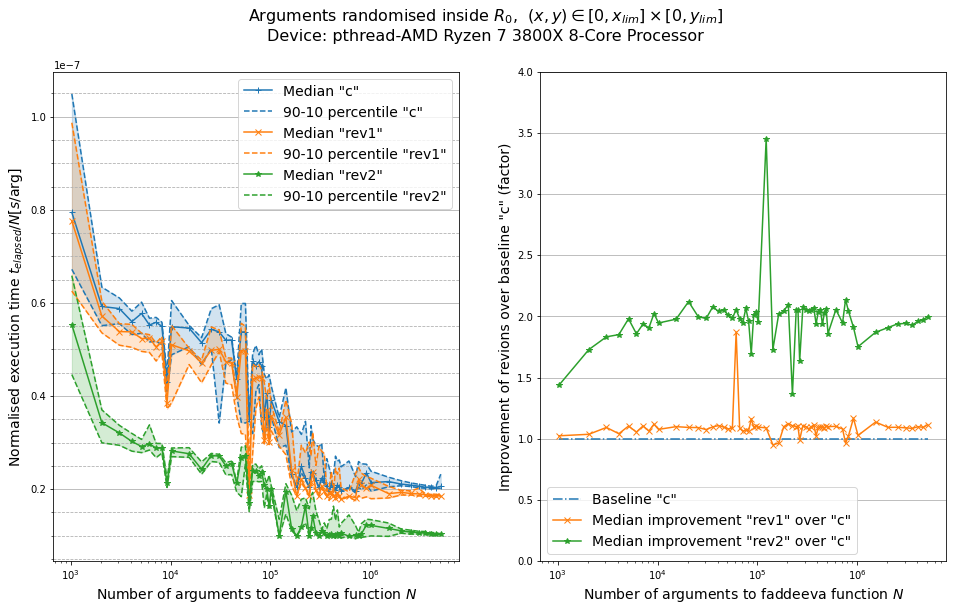

In [124]:
plot_variant_norm_times_for_device( devices[ used_device_ids[ 2 ] ], num_args, r0_random_times[ used_device_ids[ 2 ] ], title_str)
plt.rcParams["figure.figsize"] = (12,9)
plt.savefig( './cmp_opencl_randomised_r0_amd_3800X_cpu_pocl.svg')

## Randomised outside of $R_0$

In [51]:
outside_r0_random_times = { ii: { "c":{}, "rev1":{}, "rev2":{} } for ii in used_device_ids }
num_args = np.array( [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75,
                       80, 85, 90, 95, 100, 120, 140, 160, 180, 200, 220, 240, 250, 260, 280, 300, 
                      320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 600, 700, 750, 800, 900, 
                      1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000 ] ) * 1024
EPS  = float( 2.2e-16 )
prng = Generator(MT19937(20150512))

print( "\r\n*** cernlib_c kernel:" )

xlim = 5.33
ylim = 4.29

for ii in used_device_ids:
    print( f"**** device: {ii} :: {devices[ii]}")
    for N in num_args:
        x = prng.uniform( EPS + xlim, 1e3, N )
        y = prng.uniform( EPS + ylim, 1e3, N )
        x_out = np.zeros( N )
        y_out = np.zeros( N )
        
        print( f"*** N = {N:8d}" ) 
        kernel = prog_c[ ii ].eval_cerrf
        outside_r0_random_times[ ii ][ "c" ][ N ] = run_benchmark( 
            contexts[ii], kernel, x, y, x_out, y_out, num_repetitions=50 )

print( "\r\n*** cernlib_rev1_c kernel:" )

for ii in used_device_ids:
    print( f"**** device: {ii} :: {devices[ii]}")
    for N in num_args:
        x = prng.uniform( EPS + xlim, 1e3, N )
        y = prng.uniform( EPS + ylim, 1e3, N )
        x_out = np.zeros( N )
        y_out = np.zeros( N )
        
        print( f"*** N = {N:8d}" ) 
        kernel = prog_c_rev1[ ii ].eval_cerrf        
        outside_r0_random_times[ ii ][ "rev1" ][ N ] = run_benchmark( 
            contexts[ii], kernel, x, y, x_out, y_out, num_repetitions=50 )
        


*** cernlib_c kernel:
**** device: 0 :: <pyopencl.Device 'GeForce GTX 1050 Ti' on 'NVIDIA CUDA' at 0x2de44b0>
*** N =     1024
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     2048
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     3072
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     4096
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     5120
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     6144
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
star

start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  1024000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  1536000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2048000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2560000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3072000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3584000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =

start repetition  41 /  50
*** N =   450560
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   471040
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   491520
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   512000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   614400
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   716800
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   768000
start repetition   1 /  50
start repetition 

*** N =   256000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   266240
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   286720
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   307200
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   327680
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   348160
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   368640
start repetition   1 /  50
start repetition  11 /  50
start repetition 

start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    97280
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   102400
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   122880
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   143360
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   163840
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   184320
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =

start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    71680
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    76800
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    81920
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    87040
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    92160
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    97280
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start r

start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    35840
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    40960
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    46080
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    51200
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    56320
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =    61440
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =

In [52]:
print( "\r\n*** cernlib_rev2_c kernel:" )

for ii in used_device_ids:
    print( f"**** device: {ii} :: {devices[ii]}")
    for N in num_args:
        x = prng.uniform( EPS + xlim, 1e3, N )
        y = prng.uniform( EPS + ylim, 1e3, N )
        x_out = np.zeros( N )
        y_out = np.zeros( N )
        
        print( f"*** N = {N:8d}" ) 
        kernel = prog_c_rev2[ ii ].eval_cerrf
        outside_r0_random_times[ ii ][ "rev2" ][ N ] = run_benchmark( 
            contexts[ii], kernel, x, y, x_out, y_out, num_repetitions=50 )


*** cernlib_rev2_c kernel:
**** device: 0 :: <pyopencl.Device 'GeForce GTX 1050 Ti' on 'NVIDIA CUDA' at 0x2de44b0>
*** N =     1024
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     2048
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     3072
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     4096
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     5120
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =     6144
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50

start repetition  31 /  50
start repetition  41 /  50
*** N =  1024000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  1536000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2048000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  2560000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3072000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  3584000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =  4096000
start repetition 

start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   450560
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   471040
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   491520
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   512000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   614400
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   716800
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =

start repetition  31 /  50
start repetition  41 /  50
*** N =   256000
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   266240
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   286720
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   307200
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   327680
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   348160
start repetition   1 /  50
start repetition  11 /  50
start repetition  21 /  50
start repetition  31 /  50
start repetition  41 /  50
*** N =   368640
start repetition 

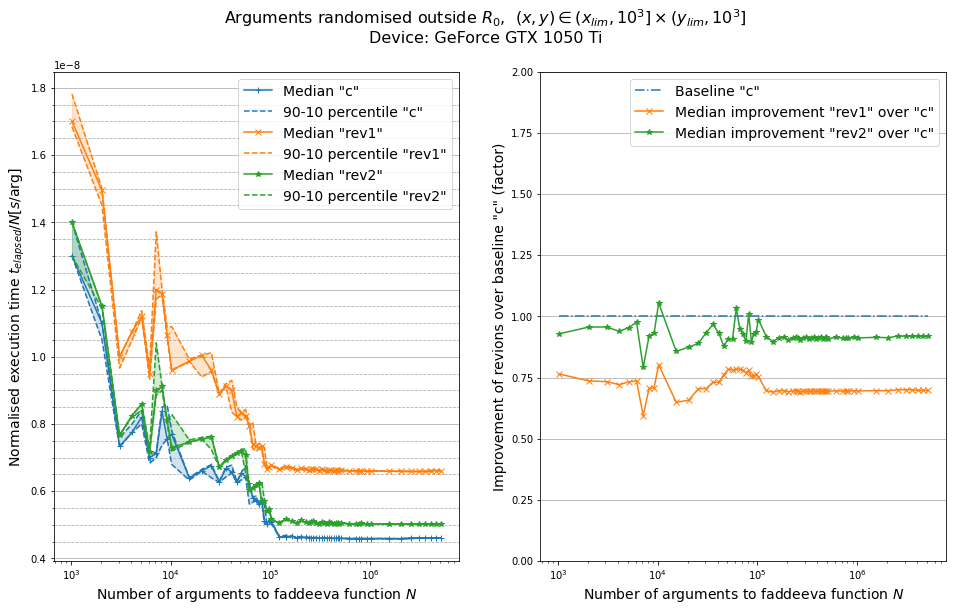

In [125]:
title_str =  r"Arguments randomised outside $R_0$,  $(x,y) \in (x_{lim}, 10^3] \times (y_{lim},10^3]$"
plot_variant_norm_times_for_device( devices[ used_device_ids[ 0 ] ], num_args, outside_r0_random_times[ used_device_ids[ 0 ] ], title_str)
plt.savefig( './cmp_opencl_random_outside_r0_nvidia_gtx1050ti_cuda11.svg')

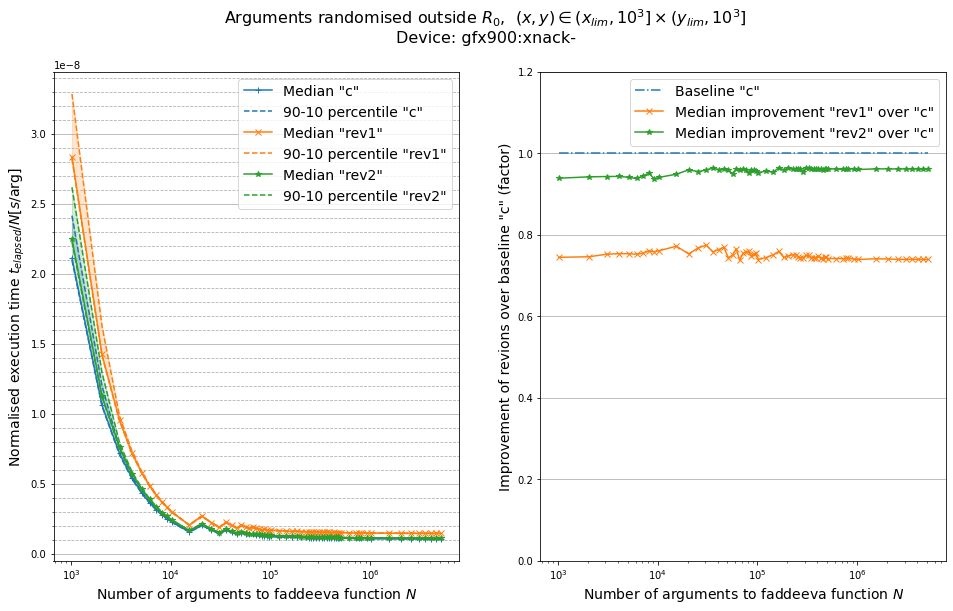

In [126]:
plot_variant_norm_times_for_device( devices[ used_device_ids[ 1 ] ], num_args, outside_r0_random_times[ used_device_ids[ 1 ] ], title_str)
plt.savefig( './cmp_opencl_random_outside_r0_amd_vega64_rocm42.svg')

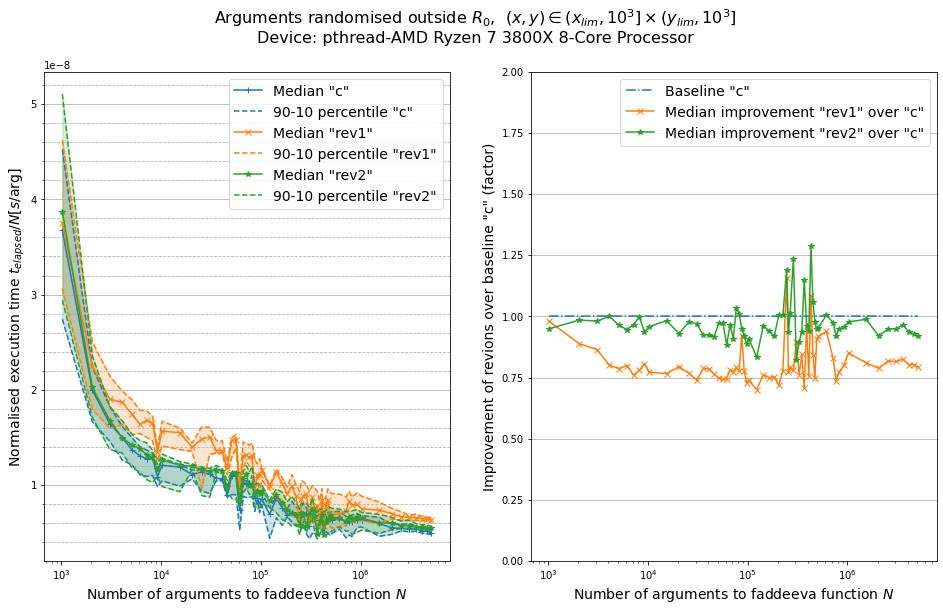

In [127]:
plot_variant_norm_times_for_device( devices[ used_device_ids[ 2 ] ], num_args, outside_r0_random_times[ used_device_ids[ 2 ] ], title_str)
plt.rcParams["figure.figsize"] = (12,9)
plt.savefig( './cmp_opencl_random_outside_r0_amd_3800x_pocl.svg')